In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
# Load XGB results
with open("xgb_results_simple.pkl", "rb") as f:
    results = pickle.load(f)

# Load S&P 500 data
# Calculate RMSE for filtering
performance = {}
for ticker, data in results.items():
    actual = data["Actual Prices"]
    predicted = data["Predicted Prices"]
    performance[ticker] = {
        "RMSE": np.sqrt(mean_squared_error(actual, predicted)),
        "Expected_Return": data["Expected Return"]
    }

performance_df = pd.DataFrame.from_dict(performance, orient="index")

performance_df

,RMSE,Expected_Return
A UN Equity,14.363762,-0.016878
AAPL UW Equity,16.043212,0.006475
ABBV UN Equity,20.048031,0.011859
ABT UN Equity,14.449679,-0.005204
ACGL UW Equity,27.014709,0.021623
...,...,...
XYL UN Equity,15.143776,0.004058
YUM UN Equity,11.884958,-0.003026
ZBH UN Equity,10.590161,-0.032191
ZBRA UW Equity,59.406404,0.034218


In [ ]:
sp500 = pd.read_excel("sp500_Cleaned_Processed.xlsx",
                      parse_dates=[0], index_col=[0])

# Load original data for volatility calculation
full_df = pd.read_excel("Stock_Features_Complete.xlsx", parse_dates=[0])

# Calculate price volatility (1 year)
price_volatility = full_df.groupby("Ticker")["Closing_Price"].std()

# Filter criteria: RMSE < 50% of price volatility
valid_tickers = [
    ticker for ticker in performance_df.index
    if performance_df.loc[ticker, "RMSE"] < 0.5 * price_volatility[ticker]
]

# Select top 50 by expected return
selected_stocks = performance_df.loc[valid_tickers].nlargest(50, "Expected_Return").index.tolist()
print(selected_stocks)

['CRWD UW Equity', 'DAL UN Equity', 'GNRC UN Equity', 'HWM UN Equity', 'WELL UN Equity', 'WMT UN Equity', 'CBRE UN Equity', 'RL UN Equity', 'ANET UN Equity', 'TJX UN Equity', 'WAB UN Equity', 'CSCO UW Equity', 'HES UN Equity', 'LYV UN Equity', 'CMI UN Equity', 'CRM UN Equity', 'WRB UN Equity', 'TROW UW Equity', 'APH UN Equity', 'JCI UN Equity', 'EQT UN Equity', 'DOV UN Equity', 'AON UN Equity', 'BK UN Equity', 'AXP UN Equity', 'CTRA UN Equity', 'NOW UN Equity', 'ATO UN Equity', 'COST UW Equity', 'MAA UN Equity', 'BLK UN Equity', 'LII UN Equity', 'CTAS UW Equity', 'BKNG UW Equity', 'SPG UN Equity', 'CTSH UW Equity', 'NVDA UW Equity', 'AJG UN Equity', 'MMC UN Equity', 'REG UW Equity', 'SLB UN Equity', 'AMP UN Equity', 'GWW UN Equity', 'TEL UN Equity', 'CBOE UF Equity', 'F UN Equity', 'VLO UN Equity', 'CF UN Equity', 'DE UN Equity', 'PTC UW Equity']


In [ ]:
# Get historical log returns for covariance matrix
returns_df = full_df.pivot(index="Date", columns="Ticker", values="Log_Return")[selected_stocks]

# Get predicted returns from XGB
predicted_returns = pd.DataFrame({
    ticker: results[ticker]["Expected Return"]
    for ticker in selected_stocks
}, index=["Expected_Return"])

# Covariance matrix (annualized)
cov_matrix = returns_df.cov() * 252  # 252 trading days

# Expected returns matrix
mu = predicted_returns.values.flatten()

# Portfolio optimization function
def optimize_portfolio(mu, cov_matrix, risk_free_rate=0.04):
    def sharpe_ratio(weights):
        port_return = np.dot(weights, mu)
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(port_return - risk_free_rate) / port_vol  # Negative for minimization
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mu)))
    initial_weights = np.ones(len(mu)) / len(mu)
    
    opt = minimize(sharpe_ratio, initial_weights,
                   method="SLSQP", bounds=bounds, constraints=constraints)
    return opt.x

optimal_weights = optimize_portfolio(mu, cov_matrix)

print(optimal_weights)

[3.23861565e-01 3.43210981e-01 7.45893827e-02 2.58338071e-01
 1.94072189e-17 3.76218154e-17 1.19262239e-17 1.25767452e-17
 2.38524478e-18 0.00000000e+00 0.00000000e+00 3.07913417e-17
 2.40692882e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.76471554e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.32413868e-18 9.32413868e-18
 0.00000000e+00 0.00000000e+00 8.29414662e-18 0.00000000e+00
 1.13841228e-17 0.00000000e+00 0.00000000e+00 4.33680869e-19
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.36102673e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.05998413e-18
 0.00000000e+00 1.45283091e-17 1.27935856e-17 0.00000000e+00
 4.01154804e-18 1.65882932e-17 0.00000000e+00 1.17093835e-17
 4.55364912e-18 0.00000000e+00]


In [ ]:
portfolio_values = []
for ticker in selected_stocks:
    test_prices = results[ticker]["Actual Prices"]
    returns = np.log(test_prices[1:]/test_prices[:-1])
    portfolio_values.append(returns * optimal_weights[selected_stocks.index(ticker)])

portfolio_returns = np.sum(portfolio_values, axis=0)
cumulative_portfolio = np.exp(np.cumsum(portfolio_returns))
 
# Get S&P 500 returns for same period
sp500_returns = np.log(sp500["Closing_Price"].pct_change() + 1).dropna().values[-len(portfolio_returns):]
cumulative_sp500 = np.exp(np.cumsum(sp500_returns))
 
def calculate_metrics(returns, risk_free=0.04/12):  # Monthly risk-free
    total_return = np.exp(np.sum(returns)) - 1
    volatility = np.std(returns) * np.sqrt(12)
    sharpe = (np.mean(returns) * 12 - risk_free) / volatility
    return total_return, volatility, sharpe
 
port_return, port_vol, port_sharpe = calculate_metrics(portfolio_returns)
sp500_return, sp500_vol, sp500_sharpe = calculate_metrics(sp500_returns)
 
print(f"""
📊 Final Performance Report
---------------------------------
                   Portfolio   S&P 500
Total Return:     {port_return:.2%}     {sp500_return:.2%}
Annual Volatility: {port_vol:.2%}     {sp500_vol:.2%}
Sharpe Ratio:     {port_sharpe:.2f}       {sp500_sharpe:.2f}
""")


📊 Final Performance Report
---------------------------------
                   Portfolio   S&P 500
Total Return:     18.74%     4.37%
Annual Volatility: 30.63%     11.23%
Sharpe Ratio:     1.67       1.11



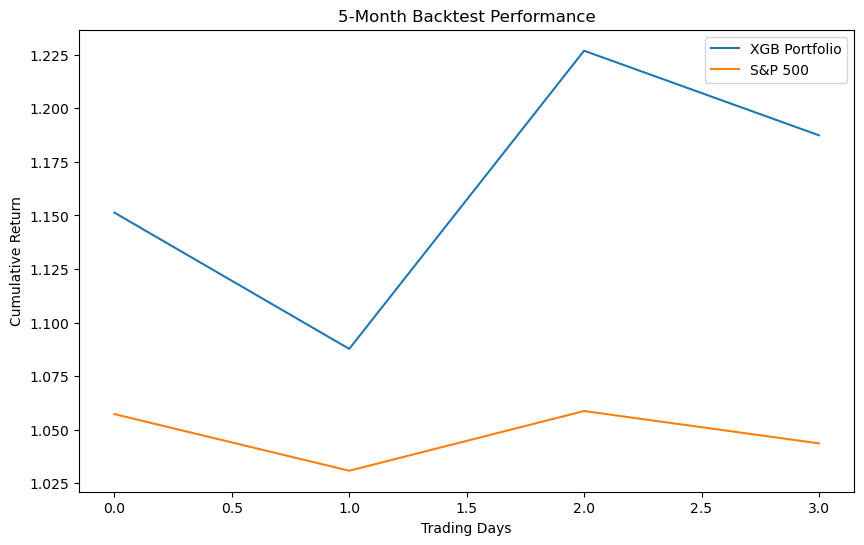

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio, label="XGB Portfolio")
plt.plot(cumulative_sp500, label="S&P 500")
plt.title("5-Month Backtest Performance")
plt.xlabel("Trading Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.savefig("xgb_performance_comparison.png")
plt.show()